## New Webpage Implementation (Analyze A/B Test Results)

Note: Meisam Heidari and I have done the project together as a team. We are both the students of the data analysis nano degree program. We are trying to work together to understand and fill the each other's gaps for better learning and project delivering.

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, I worked to understand the results of an A/B test run by an e-commerce website. The goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

In [5]:
# Number of rows having user_id replicated
df.shape[0]-df.user_id.nunique()

3894

d. The proportion of users converted.

In [6]:
df.drop_duplicates(subset='user_id').converted.mean()

0.1195695564793657

e. The number of times the `new_page` and `treatment` don't match.

In [7]:
temp = df.groupby('group')['landing_page'].value_counts()
temp['control','new_page']+temp['treatment','old_page']

3893

f. Do any of the rows have missing values?

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
df2=df[((df['landing_page']=='new_page') & (df['group']=='treatment'))|((df['landing_page']=='old_page') & (df['group']=='control'))].copy(deep=True)
# Check there are no overlaps between 'control' group and 'new_page'
# Check there are no overlaps between 'treatment' group and 'old_page'
df2.groupby('group')['landing_page'].value_counts()

group      landing_page
control    old_page        145274
treatment  new_page        145311
Name: landing_page, dtype: int64

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
# number of unoique user_ids
df2.user_id.nunique()

290584

In [12]:
# number of repeated user_ids
df2.shape[0]-df2.user_id.nunique()

1

b. There is one **user_id** repeated in **df2**.  What is it?

In [13]:
df2[df2.duplicated(subset='user_id')]['user_id'].unique()[0]

773192

c. What is the row information for the repeat **user_id**? 

In [14]:
df2[df2.duplicated(subset='user_id', keep=False)].sort_values('user_id').head()

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [15]:
df2.drop([2893],axis=0, inplace=True)

In [16]:
# double checking if it is removed
df2[df2.duplicated(subset='user_id', keep=False)].sort_values('user_id').head()

,user_id,timestamp,group,landing_page,converted


`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [17]:
print('Experiment runs between  "',df2.timestamp.min(), '"  and  "',df2.timestamp.max(),'"')

Experiment runs between  " 2017-01-02 13:42:05.378582 "  and  " 2017-01-24 13:41:54.460509 "


In [18]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [19]:
df2[df2['group']=='control']['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [20]:
df2[df2['group']=='treatment']['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [21]:
df2[df2['landing_page']=='new_page']['user_id'].count()/df2['user_id'].count()

0.5000619442226688


e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**My Answer to Part e.**
- Data is devided half and half between `control` group and `treatment`(experiment) group

- This dataset is seemingly a large dataset with 290,000 data lines over 3 weeks
- The rate of conversion in the `treatment` group is lower by the small amount of less than 1%
- the difference between `control` and `treatment` groups doesn't seem to be large enough to indicate a difference
- Considering the large dataset, we can A/B test to make sure this small difference is not meaningful

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**My Answer to Question 1**

$$H_0: p_{new} - p_{old} = 0$$


$$H_1: p_{new} - p_{old} > 0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [22]:
# Assuming null hypothesis is correct:
p_new_null = df2.converted.mean()
p_new_null

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [23]:
# Assuming null hypothesis is correct, old page would have 
# the same conversion rate as with the new page:
p_old_null = df2.converted.mean()
p_old_null

0.11959708724499628

In [24]:
# then the null hupothesis would be the difference of 
# old and new page conversions rates to be zero:
p_diff_null=p_new_null-p_old_null
p_diff_null

0.0

c. What is $n_{new}$, the number of individuals in the treatment group?

In [25]:
n_new = df2[df2.landing_page=='new_page'].converted.count()
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [26]:
n_old = df2[df2.landing_page=='old_page'].converted.count()
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [27]:
# continueing with the assumption that null hypothesis is correct:
new_page_converted = np.random.choice([0,1],size=n_new, p=[1-p_new_null,p_new_null])
new_page_converted.mean()    


0.11904892987406235

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [28]:
# continueing with the assumption that null hypothesis is correct:
old_page_converted = np.random.choice([0,1],size=n_old, p=[1-p_old_null,p_old_null])
old_page_converted.mean()  

0.11976678552252984

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [29]:
# continueing with the assumption that null hypothesis is correct, 
# the difference between the 2 conversion rates should be close to zero:
new_page_converted.mean()  - old_page_converted.mean()


-0.0007178556484674914

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [30]:
p_diff = np.array([])
for i in range(10000):
    p_new_sample = np.random.choice([0,1],size=n_new, p=[1-p_new_null,p_new_null]).mean()
    p_old_sample = np.random.choice([0,1],size=n_old, p=[1-p_old_null,p_old_null]).mean()
    p_diff=np.append(p_diff,p_new_sample-p_old_sample)
p_diff.mean()                      

8.811687819769762e-06

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

In [31]:
# Lets calculate the actual difference between the conversion rates 
# in the dataset. This is to be compared against the simulated 
# null hypothesis:
p_new_actual = df2[df2.landing_page=='new_page'].converted.mean()
p_old_actual = df2[df2.landing_page=='old_page'].converted.mean()
diff_dataset = p_new_actual-p_old_actual
diff_dataset

-0.0015782389853555567

No handles with labels found to put in legend.


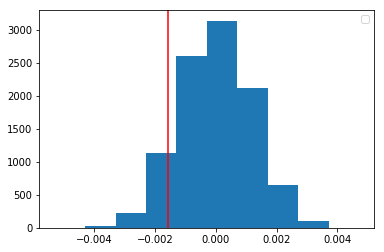

In [32]:
plt.hist(p_diff);
plt.axvline(x=diff_dataset, color='red');
plt.legend()



j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [33]:
(p_diff>diff_dataset).mean()

0.9058

In [34]:
(p_diff<diff_dataset).mean()

0.0942

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**My Answer to part j**

$$H_0: p_{new} - p_{old} = 0$$


$$H_1: p_{new} - p_{old} > 0$$

- The actual difference observed in **ab_data.csv** is called test statistic. 
- What we calculated in part j ( the number 90%) is basically the proportion of the distribution where old conversion rate is larger than the new conversion rate.  This means, the probability that we can't reject the null hypothesis. 
- Type I error(alpha) is set at 5% on the right tail.
- That means we should reject the null hypothesis if the test statistic falls in the right 5% of the null hypothesis distribution. We can see from the histogram plot that this condition is not satisfied.
- Alternatively, using the proportion calculated in part j we can get the same results. To reject the null hypothesis, we need the proportion calculated in part j to be smaller than 5%. Considering the calculated proportion is 90%,which is much larger than 5%, we fail to reject the null hypothesis
- That means, based on the given dataset, we don't have enough stistical evidence to support that the new page is increasing the conversion rate

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [35]:
import statsmodels.api as sm

convert_old = df2[(df2['landing_page']=='old_page') & (df2['converted']==1)].user_id.count()
convert_new = df2[(df2['landing_page']=='new_page') & (df2['converted']==1)].user_id.count()
n_old = df2[df2['landing_page']=='old_page'].user_id.count()
n_new = df2[df2['landing_page']=='new_page'].user_id.count()
convert_new, convert_old, n_old,n_new

(17264, 17489, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [36]:
zstat,p_value = sm.stats.proportions_ztest([convert_new,convert_old],[n_new,n_old], alternative='larger')
zstat,p_value

(-1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Put your answer here.**
- This calculation shows that assuming a standard normal z distribution for the null hypothesis, z-score of the test statistic is -1.31 and the probability associated with it is about 91%. 
- Based on the acceptable type I error of only 5%, to reject the null hypothesis, we need the probability to be smaller than 5%
- As a result, similar to our own calculation, we fail to reject the null hypothesis.
- That means, based on the given dataset, we don't have enough stistical evidence to support that the new page is increasing the conversion rate

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Put your answer here.**

Logistic Regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [37]:
df2['intercept']=1
df2['ab_page'] = pd.get_dummies(df2['group']).treatment
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [72]:
log_m = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
log_results= log_m.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [73]:
print(log_results.summary())

                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 03 Jun 2019   Pseudo R-squ.:               8.077e-06
Time:                        14:29:18   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007


e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**Put your answer here.**
- p-value associated with ab_page is 0.19(19%) which is higher than 5% significance level(Type 1 error). So the effect of ab_page on the conversion rate is NOT significant. 

- Also, note that ab_page coefficient is -0.0150 which is between the 95% confidence interval of [-0.037,0.007]. so the coefficient calculated by the model for ab_page falls inside the 95% confidence interval where null hypothesis can not be rejected. This double confirms that we should not reject the null hypothesis.



f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Put your answer here.**
- Yes, we need to find other factors which may have a more significant relationship with the conversion rate.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [41]:
df_country= pd.read_csv('countries.csv')
df_country.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [42]:
df2 = df2.join(df_country.set_index('user_id'), on='user_id')
df2.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 8 columns):
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
intercept       290584 non-null int64
ab_page         290584 non-null uint8
country         290584 non-null object
dtypes: int64(3), object(4), uint8(1)
memory usage: 18.0+ MB


In [43]:
df2.country.unique()

array(['US', 'CA', 'UK'], dtype=object)

In [74]:
df2[['US','CA','UK']] = pd.get_dummies(df2['country'])[['US','CA','UK']]

df2.head(10)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,US,CA,UK
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,1,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,1,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,1,0,0
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,US,1,0,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,0,1,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,US,1,0,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,0,0,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,0,1,0


In [75]:
Log_model = sm.Logit(df2['converted'], df2[['intercept','US','CA']])
results= Log_model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 03 Jun 2019   Pseudo R-squ.:               1.521e-05
Time:                        14:39:51   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9868      0.011   -174.174      0.000      -2.009      -1.964
US            -0.0099      0.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [46]:
log_country= sm.Logit(df2['converted'], df2[['intercept','ab_page', 'US','CA']])
log_country_results= log_country.fit()
print(log_country_results.summary())

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 03 Jun 2019   Pseudo R-squ.:               2.323e-05
Time:                        13:28:31   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9794      0.013   -155.415      0.000      -2.004      -1.954
ab_page       -0.0149      0.

**Understanding the results**
- **The effect of countries**
    - all the p-values are larger than the acceptable type I error of 0.05 (5%). This suggest that the country metric alone is not an important metric in predicting the conversion rates. We cant reject the null hypothesis.
- **The effect of countries and ab_page**
    - all the p-values are larger than the acceptable type I error of 0.05 (5%). This suggest that the country metric along with ab_page metric are not an important metric in predicting the conversion rates. We cant reject the null hypothesis.


**Analysing the quality of relationship in Scikit-learn:**

We will use scikit-learn library to create a model and then calculate the accuracy, precision and recal metrics over the test portion of the dataset. We will then compare the resulting interpretaion with our interpretation of P-Values from the statsmodel.api

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix

In [70]:
y=df2['converted']

X=df2[['CA','US','ab_page']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [71]:
log_mod = LogisticRegression()
log_mod.fit(X_train, y_train)
y_preds = log_mod.predict(X_test)
print(precision_score(y_test, y_preds))
print(recall_score(y_test, y_preds))
print(accuracy_score(y_test, y_preds))
confusion_matrix(y_test, y_preds)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.0
0.0
0.8806565952028631


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


array([[25591,     0],
       [ 3468,     0]], dtype=int64)

**Model Diagnostics**

- The precision and recall metrics are 0 which suggest the combination of above selected explanatory variables are not able to correctly predict the conversion rate at all.
- Interestingly, the accuracy score of 0.88 suggest that our model is predicting the response varriable correct in 0.88(88%) of the times. This is awfully close to the rate of not-converted users in the whole dataset(0.88).
- In general, the logistic regression model in scikit-learn confirms our results from stats.api model. neither of countries or ab_page are god explanatory variables to predict the conversion rate in the response variable.